# Проект: Обучение с учителем: качество модели

_____
**Описание исследования.**

Интернет-магазин «В один клик» продаёт товары для детей, для дома, мелкую бытовую технику, косметику и продукты.
Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

_____
**Цель исследования.**
    
Разработка решения, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.
    
_____
**Задачи исследования.**

Для того, чтобы достичь поставленной цели необходимо решить ряд задач:

- провести исследовательский анализ полученных данных (проверить данные на наличие ошибок);
- построить модель, качество которой будет удовлетворять требованиям заказчика;
- протестировать полученную модель на тестовой выборке и сделать выводы;
- выделить сегменты покупателей и разработать для них персонализированные предложения.
_____
**Исходные данные.**

`market_file.csv` :
таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

`market_money.csv` :
таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

`market_time.csv` :
таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

`money.csv` : 
таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

!pip install --upgrade scikit-learn -q
!pip install matplotlib==3.5.0 -q
!pip install phik -q
!pip install shap -q

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from phik.report import plot_correlation_matrix
from phik import phik_matrix
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, PolynomialFeatures
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
import shap

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
div.output_stderr {
    background: #0C0;
}
</style>
""")

In [3]:
sns.set_theme(rc={'figure.figsize':(6,6)})

In [4]:
pd.set_option('display.max_colwidth', None)

</font><font color='Blue'><b>Коммментарий</b></font><br>

Произвел необходимые импорты.

## Загрузка данных

In [5]:
market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')

In [6]:
market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')

In [7]:
market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')

In [8]:
money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv',decimal = ',',sep=';')

In [9]:
market_file.head(3)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5


In [10]:
market_money.head(3)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0


In [11]:
market_time.head(3)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10


In [12]:
money.head(3)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13


</font><font color='Blue'><b>Коммментарий</b></font><br>

Загрузил необхомые файлы и отобразил первые три строки получившихся датафреймов.

## Предобработка данных

In [13]:
df_list = [market_file, market_money, market_time, money]

In [14]:
def informer(df):
    display(df.sample(5))
    df.info()    
    display(f'Количество дубликатов: {df.duplicated().sum()}')

</font><font color='Blue'><b>Коммментарий</b></font><br>

Написал функцию, которая отображает основную информацию датафрейма, 5 случайных строк датафрейма и количество дубликатов в датафрейме. Создал список с датафремами, чтобы далее обращаться к списку, а не к каждому датафрейму по-отдельности.

### Основная информация о датафреймах

In [15]:
for df in df_list:
    informer(df)    
    display('*'*100)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
1189,216537,Прежний уровень,премиум,да,4.4,4,873,0.30,Косметика и аксесуары,6,4,3,4
295,215643,Снизилась,премиум,да,4.8,4,672,0.39,Товары для детей,1,5,4,6
70,215418,Снизилась,стандарт,нет,1.7,4,472,0.94,Домашний текстиль,2,6,4,3
240,215588,Снизилась,стандарт,да,3.9,5,529,0.36,Домашний текстиль,2,6,2,1
30,215378,Снизилась,стандарт,да,1.7,3,488,0.39,Техника для красоты и здоровья,5,1,4,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

'Количество дубликатов: 0'

'****************************************************************************************************'

,id,Период,Выручка
3582,216542,предыдущий_месяц,5173.0
1961,216001,текущий_месяц,6835.4
2283,216109,предыдущий_месяц,5304.0
2044,216029,препредыдущий_месяц,4837.0
2285,216109,препредыдущий_месяц,5178.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


'Количество дубликатов: 0'

'****************************************************************************************************'

,id,Период,минут
899,215797,текущий_месяц,17
2550,216623,предыдцщий_месяц,11
571,215633,текущий_месяц,13
1507,216101,предыдцщий_месяц,15
32,215364,текущий_месяц,9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


'Количество дубликатов: 0'

'****************************************************************************************************'

,id,Прибыль
679,216027,3.10
959,216307,3.16
723,216071,4.35
837,216185,4.66
104,215452,4.50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


'Количество дубликатов: 0'

'****************************************************************************************************'

</font><font color='Blue'><b>Коммментарий</b></font><br>

Отобразил основуню информацию о 4 датафремах. В глаза сразу бросаются:
* наличие пробелов в наименованиях колонок, разные регистры;
* опечатки в строковых значениях;
* дубликаты, которые содержатся только датафрейме с данными о среднемесячной прибыли продавца за последние 3 месяца.

In [16]:
def df_repair(df):
    df.columns=df.columns.str.lower()
    df.columns=df.columns.str.replace(' ','_')
    return df

</font><font color='Blue'><b>Коммментарий</b></font><br>

Написал функцию, которая меняет регистр в наименованих колонок датафреймов и заменяет пробелы на нижний прочерк.

### Исправление наименований колонок

In [17]:
for df in df_list:
    df = df_repair(df)

In [18]:
for df in df_list:
    display(df.columns)
    display('*'*100)

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

'****************************************************************************************************'

Index(['id', 'период', 'выручка'], dtype='object')

'****************************************************************************************************'

Index(['id', 'период', 'минут'], dtype='object')

'****************************************************************************************************'

Index(['id', 'прибыль'], dtype='object')

'****************************************************************************************************'

</font><font color='Blue'><b>Коммментарий</b></font><br>

Исправил наименования колонок в датафреймах, проверил результат.

In [19]:
def value_counter(df):
    for i in df.select_dtypes(exclude=np.number).columns:
        display(df[i].value_counts());
        display('*'*100)

</font><font color='Blue'><b>Коммментарий</b></font><br>

Написал функцию, которая считает количество значений в столбцах, которые содержат строковые значения.

### Проверка на наличие неявных дубликатов в датафреймах

In [20]:
value_counter(market_file)

покупательская_активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64

'****************************************************************************************************'

тип_сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64

'****************************************************************************************************'

разрешить_сообщать
да     962
нет    338
Name: count, dtype: int64

'****************************************************************************************************'

популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64

'****************************************************************************************************'

</font><font color='Blue'><b>Коммментарий</b></font><br>

Применил функцию для подсчета значений в колонках датафрейма `market_file`.
В датафрейме обнаружил неявные дубликаты в колонках 'тип_сервиса', которые далее необходимо будет исправить.

In [21]:
value_counter(market_money)

период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64

'****************************************************************************************************'

</font><font color='Blue'><b>Коммментарий</b></font><br>

Также применил функцию для подсчета значений в колонках датафрейма `market_money` - неявных дубликатов не обнаружил.

In [22]:
value_counter(market_time)

период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: count, dtype: int64

'****************************************************************************************************'

</font><font color='Blue'><b>Коммментарий</b></font><br>

Также применил функцию для подсчета значений в колонках датафрейма `market_time` - неявных дубликатов не обнаружил, но имеется опечатка 'предыдцщий_месяц'.

In [23]:
value_counter(money)

</font><font color='Blue'><b>Коммментарий</b></font><br>

Применил функцию для подсчета значений в колонках датафрейма `money`, чтобы убедиться в том, что колонки со строковыми значениями отсутствуют.

### Устранение неявных дубликатов

In [24]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт','стандарт')

In [25]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц','предыдущий_месяц')

</font><font color='Blue'><b>Коммментарий</b></font><br>

Устранил неявные дубликаты и ошибки в датафреймах `market_file` и `market_time`.

In [26]:
value_counter(market_file)

покупательская_активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64

'****************************************************************************************************'

тип_сервиса
стандарт    924
премиум     376
Name: count, dtype: int64

'****************************************************************************************************'

разрешить_сообщать
да     962
нет    338
Name: count, dtype: int64

'****************************************************************************************************'

популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64

'****************************************************************************************************'

In [27]:
value_counter(market_time)

период
текущий_месяц       1300
предыдущий_месяц    1300
Name: count, dtype: int64

'****************************************************************************************************'

</font><font color='Blue'><b>Коммментарий</b></font><br>

Регистры и пробелы в строках менять не стал, так как главной задачей было устранить именно дубликаты, ниже эти столбцы попадут в энкодеры поэтому такие значения не повлияют на результат работы модели.

### Контрольная проверка исправленных датафреймов

In [28]:
market_file['тип_сервиса'].value_counts()

тип_сервиса
стандарт    924
премиум     376
Name: count, dtype: int64

In [29]:
market_time['период'].value_counts()

период
текущий_месяц       1300
предыдущий_месяц    1300
Name: count, dtype: int64

In [30]:
informer(market_file)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
552,215900,Снизилась,стандарт,да,4.8,4,907,0.30,Косметика и аксесуары,2,1,1,6
729,216077,Прежний уровень,премиум,да,4.9,4,763,0.25,Мелкая бытовая техника и электроника,2,2,2,17
540,215888,Прежний уровень,стандарт,нет,5.2,3,228,0.11,Техника для красоты и здоровья,6,1,2,5
1063,216411,Прежний уровень,стандарт,да,5.1,4,602,0.23,Товары для детей,2,2,8,9
1092,216440,Прежний уровень,стандарт,да,3.2,4,703,0.30,Мелкая бытовая техника и электроника,2,1,6,6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

'Количество дубликатов: 0'

In [31]:
informer(market_time)

,id,период,минут
2408,216552,текущий_месяц,16
1712,216204,предыдущий_месяц,20
2007,216351,текущий_месяц,12
1245,215970,предыдущий_месяц,12
1215,215955,текущий_месяц,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


'Количество дубликатов: 0'

</font><font color='Blue'><b>Коммментарий</b></font><br>

Проверил результат исправлений в датафреймах `market_file` и `market_time`.

In [32]:
def informer(df):
    df.info()
    df.sample(5)
    display(f'Количество дубликатов: {df.duplicated().sum()}')

In [33]:
for df in df_list:
    informer(df)
    display('*'*100);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

'Количество дубликатов: 0'

'****************************************************************************************************'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


'Количество дубликатов: 0'

'****************************************************************************************************'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


'Количество дубликатов: 0'

'****************************************************************************************************'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


'Количество дубликатов: 0'

'****************************************************************************************************'

### Предобработка данных. Вывод 

</font><font color='Blue'><b>Коммментарий</b></font><br>

В результате предобработки данных:
* найдены и устранены ошибки в наименованиях колонок;
* найдены и устранены опечатки в строковых значениях датафреймов;
* найдены и устранены неявные дубликаты в датафремах.

## Исследовательский анализ данных

### Анализ данных о поведении покупателя на сайте, коммуникациях и продуктовом поведении

In [34]:
def plotys(df, cols_to_drop=[], figsize=(12,5), bins=30):
    
    df = df.drop(cols_to_drop,axis=1).select_dtypes(include=np.number)
    
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
    axes = axes.flatten()
    
    for i, column in enumerate(df.columns):
        df[column].hist(ax=axes[i],edgecolor='white',color='#ffc0cb', bins=bins)
        axes[i].set_title(f'Распределение значений колонки\n "{column}"') 
        axes[i].set_xlabel(f'Значения колонки') 
        axes[i].set_ylabel('Частота') 
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.7, wspace=0.2)
    plt.show()

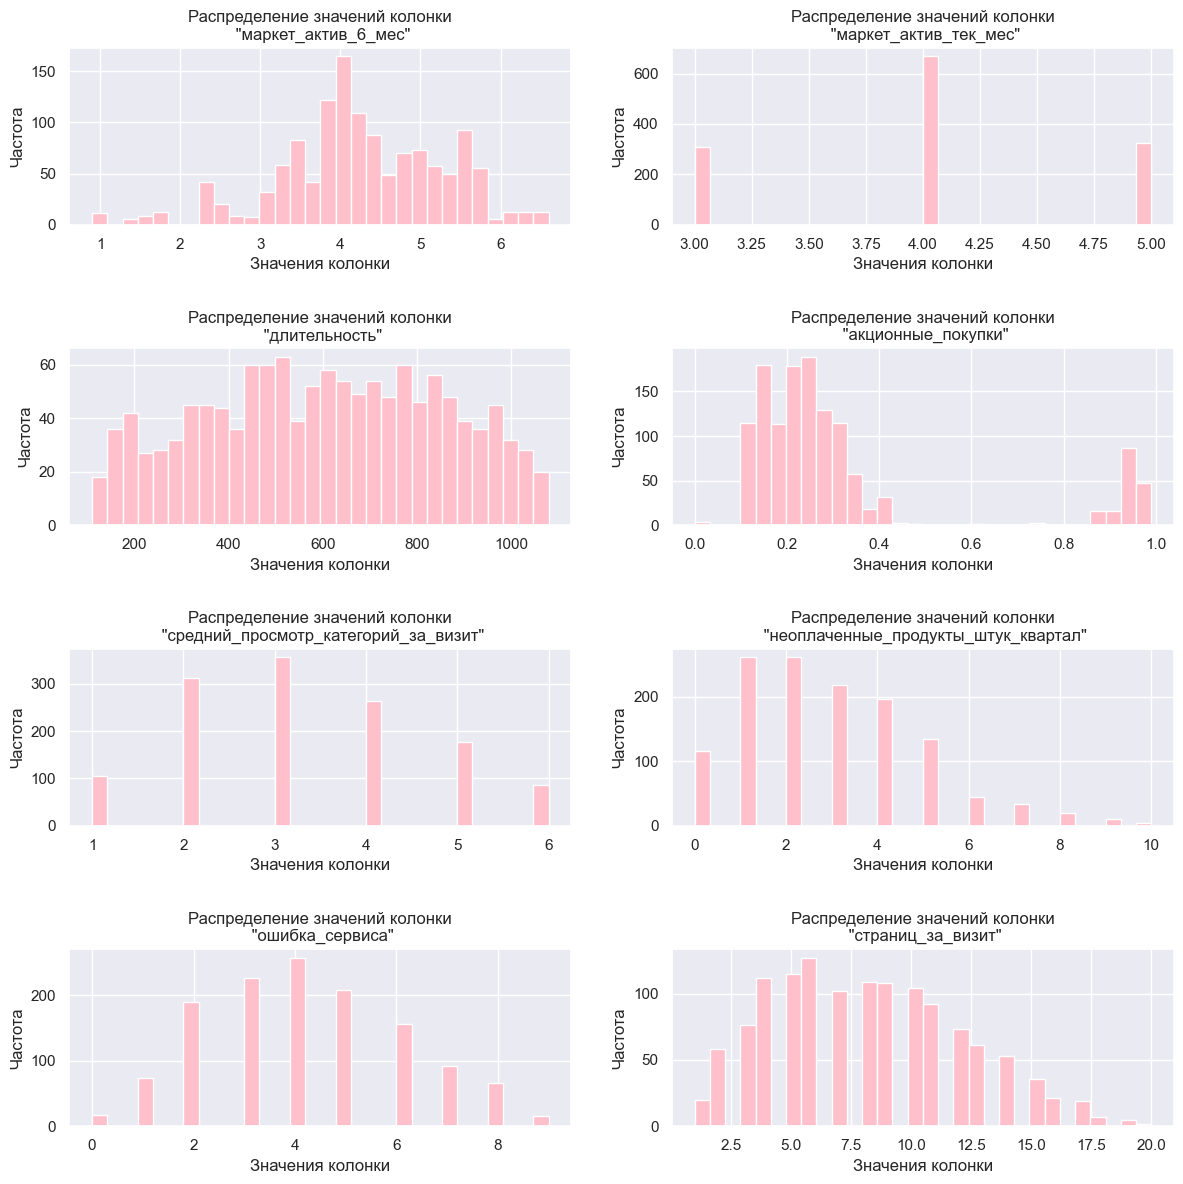

In [35]:
plotys(market_file, 'id')

</font><font color='Blue'><b>Коммментарий</b></font><br>

Построил гистограммы распределения количественных признаков датафрейма `market_file`, выбросы можно заметить только в колонках 'акционные_покупки' и 'маркет_актив_6_мес'.

### Анализ данных о времени, которое покупатель провёл на сайте в течение периода

In [36]:
def plotys_box(df, cols_to_drop=[], figsize=(12,5), bins=30):
    
    df = df.drop(cols_to_drop,axis=1).select_dtypes(include=np.number)

    for i in df:
        fig, ax = plt.subplots(2, figsize=figsize)
        ax[0].boxplot(df[i],vert=False)
        ax[0].set_title(f'Ящик с усами для колонки "{i}"')
        ax[0].set_yticks([])
        ax[0].set_ylabel(f'Колонка \n"{i}"')
        ax[0].set_xlabel(f'Значения колонки "{i}"')
        
        ax[1].hist(df[i],bins=bins, color='#ffc0cb')
        ax[1].set_title(f'Гистограмма для колонки "{i}"')
        ax[1].set_ylabel(f'Частота')
        ax[1].set_xlabel(f'Значения колонки "{i}"')
        fig.subplots_adjust(hspace=0.7, wspace=0.3)
        #plt.show()

In [37]:
market_time.head(2)

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13


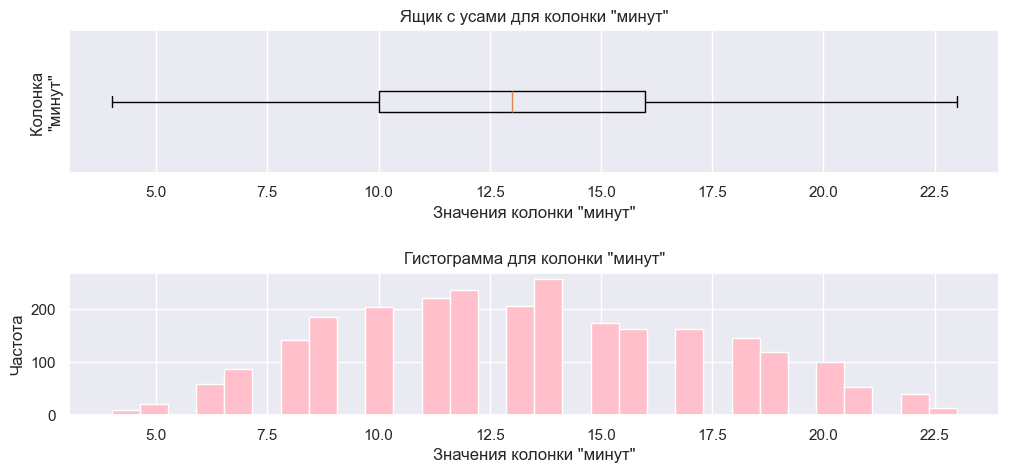

In [38]:
plotys_box(market_time, 'id')

</font><font color='Blue'><b>Коммментарий</b></font><br>

Построил гистограммы распределения количественных признаков датафрейма `market_time`. В датафрейме встетился только один количественный признак - значения этого признака распределены нормально. Выбросов не обнаружил.

### Анализ данных о выручке с покупателя

In [39]:
market_money.head(2)

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1


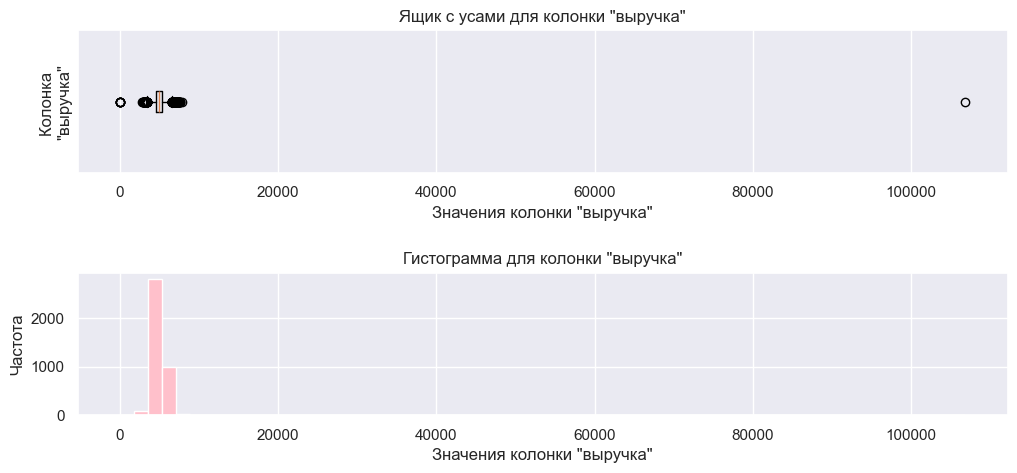

In [40]:
plotys_box(market_money, 'id', bins=60)

</font><font color='Blue'><b>Коммментарий</b></font><br>

Построил гистограмму с распределением и ящик с усами количественных признаков датафрейма `market_money`, выбросы встретились в колонке 'выручка'.

In [41]:
market_money[market_money['выручка']>20000]

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [42]:
money[money['id']==215380]

,id,прибыль
32,215380,3.88


In [43]:
market_money[market_money['id']==215380]

,id,период,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


In [44]:
market_money = market_money[market_money['выручка']<20000]

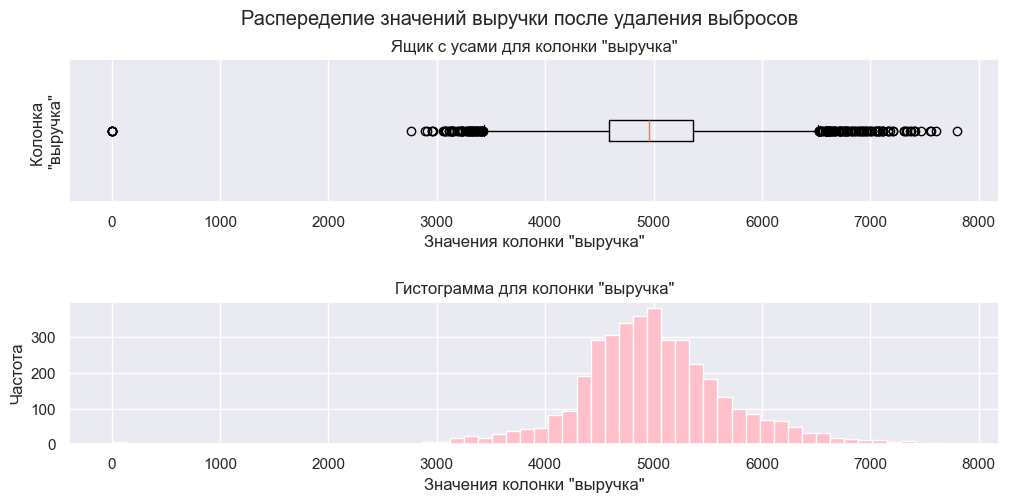

In [45]:
plotys_box(market_money, 'id', bins=60)
plt.suptitle('Распеределие значений выручки после удаления выбросов');

</font><font color='Blue'><b>Коммментарий</b></font><br>

Удалил строки с выбросами в колонке с выручкой и отобразил результат при помощи ящика с усами.

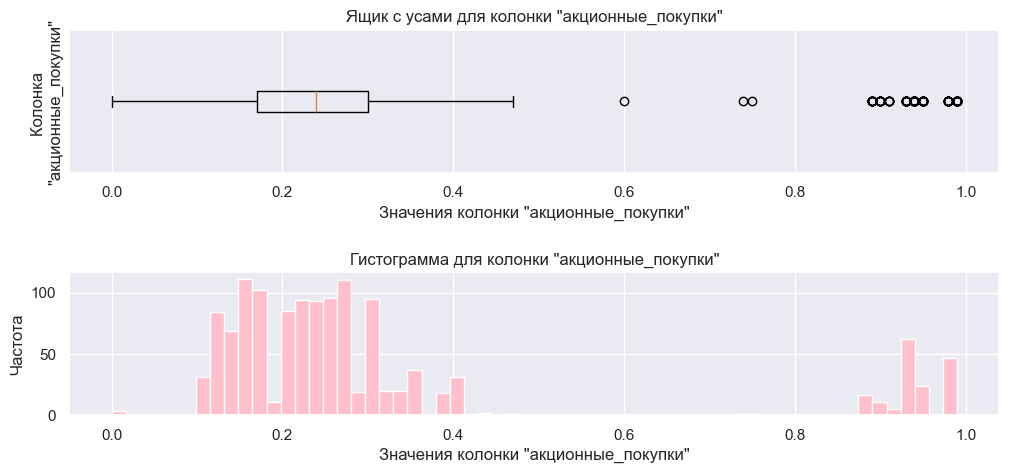

In [46]:
plotys_box(market_file[['акционные_покупки']], bins=60)

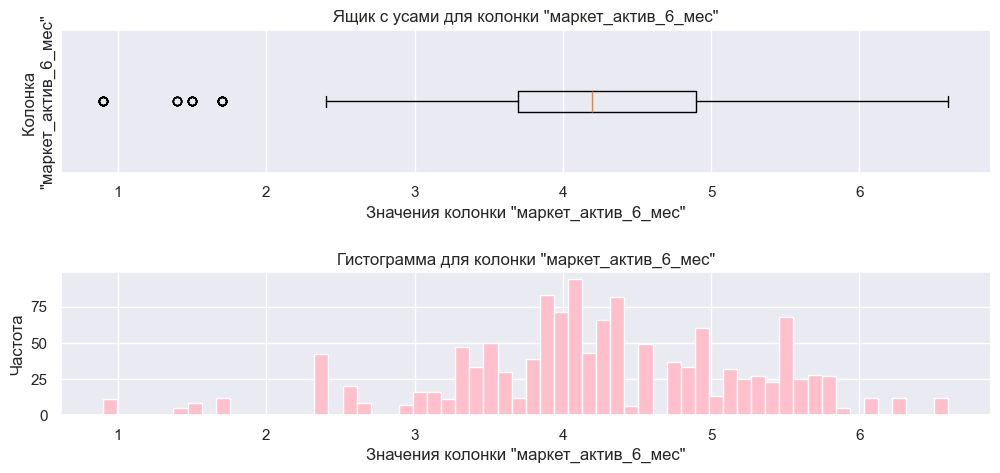

In [47]:
plotys_box(market_file[['маркет_актив_6_мес']], bins=60)

</font><font color='Blue'><b>Коммментарий</b></font><br>

Таким же образом отобразил, как распределены значения в колонках с показателями среднемесячной доли покупок по акции от общего числа покупок за последние 6 месяцев и показателем маркетинговой активности за последние 6 месяцев - данные выглядят адекватно.

In [48]:
df_list = [market_file,market_money,market_time,money]

</font><font color='Blue'><b>Коммментарий</b></font><br>

Обновил список с датафреймами, так как содержание датафреймов изменилось. 

In [49]:
for i in df_list:
    display(informer(i))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

'Количество дубликатов: 0'

None

<class 'pandas.core.frame.DataFrame'>
Index: 3899 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3899 non-null   int64  
 1   период   3899 non-null   object 
 2   выручка  3899 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 121.8+ KB


'Количество дубликатов: 0'

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


'Количество дубликатов: 0'

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


'Количество дубликатов: 0'

None

### Поиск клиентов, которые проявили "неактивность" за последние три месяца

In [50]:
intermittent_clients = market_money.loc[market_money['выручка']==0,'id'].unique()

In [51]:
intermittent_clients

array([215348, 215357, 215359], dtype=int64)

In [52]:
f'Количество клиентов, которые проявили "неактивность" за последние три месяца: {len(intermittent_clients)}'

'Количество клиентов, которые проявили "неактивность" за последние три месяца: 3'

In [53]:
market_money.loc[market_money['выручка']==0]

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


</font><font color='Blue'><b>Коммментарий</b></font><br>

Клиенты (и их id), которые не совершали покупки в какой - то из трех последних месяцев внес в список `intermittent_clients`, ниже эти id будут удалены из обучающей выборки.

### Исследовательский анализ данных. Вывод

</font><font color='Blue'><b>Коммментарий</b></font><br>

В ходе исследовательского анализа данных были определены колиичественные признаки и удален выброс из данных с выручкой.

## Объединение таблиц

In [54]:
pivot_time = market_time.pivot(columns='период',index='id',values='минут');pivot_time.head(3)

период,предыдущий_месяц,текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13


</font><font color='Blue'><b>Коммментарий</b></font><br>

Составил pivot таблицу `pivot_time`, в которой содержатся данные о времени (в минутах), которое покупатель провёл на сайте в предыдущем и текущем месяцах - данные теперь разбиты на две соответствующие колонки.

In [55]:
pivot_time.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   предыдущий_месяц  1300 non-null   int64
 1   текущий_месяц     1300 non-null   int64
dtypes: int64(2)
memory usage: 30.5 KB


In [56]:
pivot_money = market_money.pivot(columns='период',index='id', values='выручка');pivot_money.head(3)

период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4


In [57]:
pivot_money.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348 to 216647
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   предыдущий_месяц     1300 non-null   float64
 1   препредыдущий_месяц  1300 non-null   float64
 2   текущий_месяц        1299 non-null   float64
dtypes: float64(3)
memory usage: 40.6 KB


</font><font color='Blue'><b>Коммментарий</b></font><br>

Составил pivot таблицу `pivot_money`, в которой содержатся данные о выручке, которую магазин получил с покупателя. В таблице содержатся пропуски, так как некоторые из пользователей, могли еще не совершить покупку в текущем месяце. Далее избавимся от них в таблице, в которой будут содержатся все данные, в том числе id пользователей.

In [58]:
pivot_join = pivot_money.join(pivot_time,rsuffix='_минут');pivot_join.head(3)

период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц,предыдущий_месяц_минут,текущий_месяц_минут
id,,,,,
215348,0.0,0.0,3293.1,13,14
215349,5216.0,4472.0,4971.6,12,10
215350,5457.5,4826.0,5058.4,8,13


</font><font color='Blue'><b>Коммментарий</b></font><br>

Объединил две pivot таблицы в одну и указал в качестве суфикса "минут", так как в таблицах встретилсь одинаковые наименования столбцов. Пропуски также не удаляю.

In [59]:
giga_df = market_file.set_index('id').join(pivot_join)

In [60]:
giga_df = market_file.set_index('id').join(pivot_join).dropna()

In [61]:
giga_df = giga_df.loc[~giga_df.index.isin(intermittent_clients)]

In [62]:
giga_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   object 
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит            

In [63]:
display(f'Количество уникальных клиетов в общей таблице: {len((giga_df.index).unique())}')
f'Количество клиетов в общей таблице: {len(giga_df)}'

'Количество уникальных клиетов в общей таблице: 1296'

'Количество клиетов в общей таблице: 1296'

</font><font color='Blue'><b>Коммментарий</b></font><br>

Объединил все таблицы в одну `giga_df` и удалил строки, в которых образовались пропуски. Вывел информацию о получившейся таблице.

### Объединение таблиц. Вывод 

</font><font color='Blue'><b>Коммментарий</b></font><br>

В результате объединения таблиц:
* было обнаружено, что не у всех клиентов имеются данные о выручке по каждому из последних трех месяцев;
* составлена общая таблица, в которой содержится вся доступная для нас информация;
* удалены из общей таблицы строки с получившимися пропусками.

## Корреляционный анализ

### Построение матрицы корреляций с целевым признаком

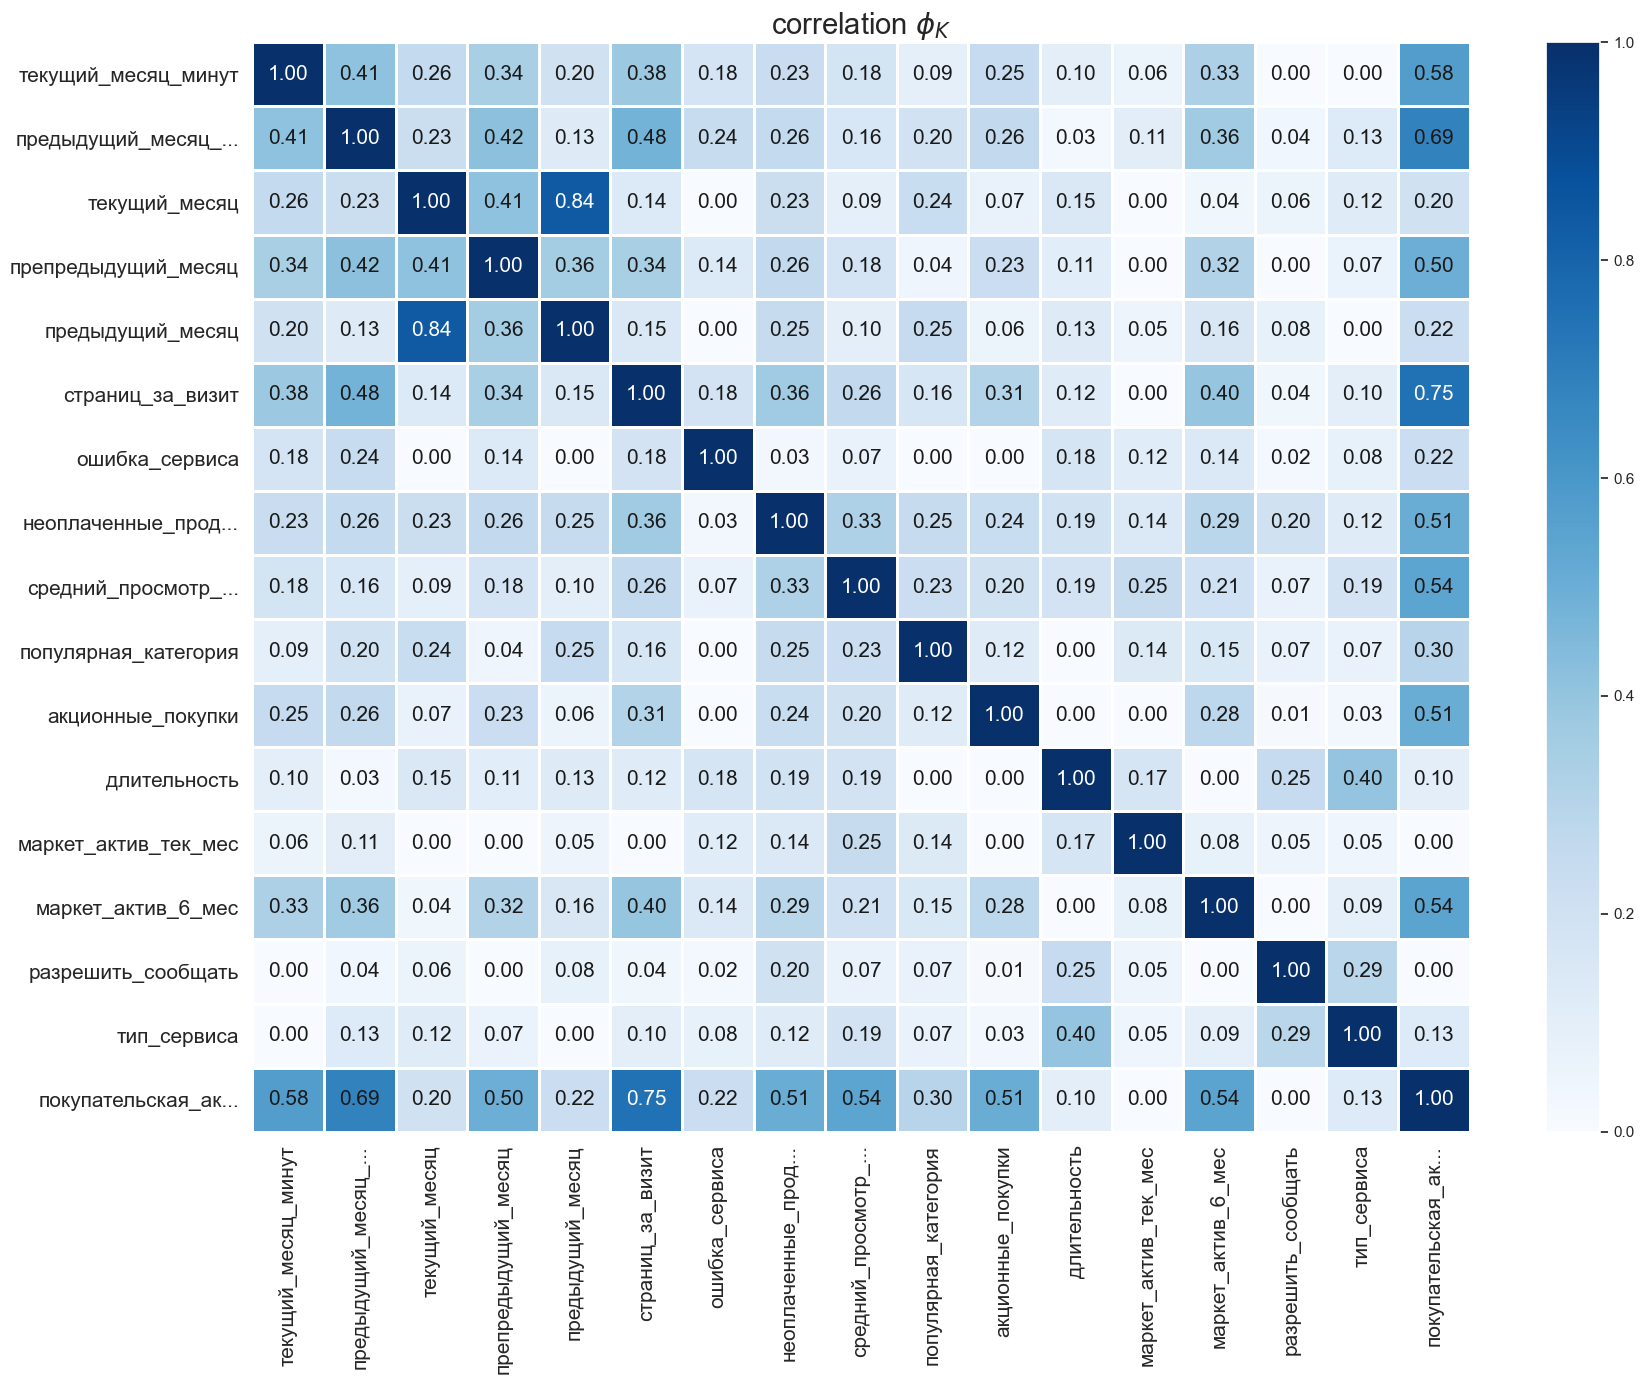

In [64]:
phik_overview = phik_matrix(giga_df,verbose=False)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(18, 14)
) 

</font><font color='Blue'><b>Коммментарий</b></font><br>

Построил матрицу корреляций с целевым признаком при помощи корреляции Спирмана, так как в данных присутствуют признаки, которые не распределены нормально и в данных присутствуют категориальные признаки.


In [65]:
phik_overview['покупательская_активность'].sort_values(ascending=False)

покупательская_активность              1.000000
страниц_за_визит                       0.749888
предыдущий_месяц_минут                 0.685138
текущий_месяц_минут                    0.576770
маркет_актив_6_мес                     0.544831
средний_просмотр_категорий_за_визит    0.539607
акционные_покупки                      0.506276
неоплаченные_продукты_штук_квартал     0.505655
препредыдущий_месяц                    0.497393
популярная_категория                   0.299717
предыдущий_месяц                       0.224638
ошибка_сервиса                         0.224154
текущий_месяц                          0.197213
тип_сервиса                            0.129940
длительность                           0.099901
маркет_актив_тек_мес                   0.000000
разрешить_сообщать                     0.000000
Name: покупательская_активность, dtype: float64

</font><font color='Blue'><b>Коммментарий</b></font><br>

Сделал срез с коррелирующими с целевым признаком признаками.

### Корреляционный анализ. Вывод

</font><font color='Blue'><b>Коммментарий</b></font><br>

После проведенного корреляционного анализа можно обнаружить, что с целевым признаком `покупательская_активность` хорошо коррелируют (по шкале Чеддока сила связи "заметная" и выше) следующие признаки:
* количество страниц за визит ( `страниц_за_визит` );
* значение времени, проведённого на сайте за предыдущий месяц в минутах ( `предыдущий_месяц_минут` );
* значение времени, проведённого на сайте в текущем месяце в минутах ( `текущий_месяц_минут` );
* среднее значение просмотренных категорий за последний месяц ( `средний_просмотр_категорий_за_визит` );
* среднемесячное значение маркетинговых коммуникаций компании за 6 месяцев ( `маркет_актив_6_мес` );
* среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев( `акционные_покупки` );
* выручка, которую получил магазин с покупателя за препредыдущий месяц( `препредыдущий_месяц` )

Ни один признаков, который коррелирует с целевым признаком, не коррелирует между остальными с коэффициентом большим, чем 0.53, поэтому все признаки было решено оставить.

## Использование пайплайнов

### Создание списков с названиями признаков

In [66]:
ohe_columns=['тип_сервиса','разрешить_сообщать']

num_columns=['маркет_актив_6_мес',
       'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'предыдущий_месяц', 'препредыдущий_месяц',
       'текущий_месяц', 'предыдущий_месяц_минут', 'текущий_месяц_минут']  

ord_columns=['популярная_категория'] 

</font><font color='Blue'><b>Коммментарий</b></font><br>

Создал три списка с названиями признаков для их дальнейшего преобразования и использования в моделях: 
* `ohe_columns`  для бинарных признаков ;
* `num_columns` для количественных признаков;
* `ord_columns` для признаков с количеством категорий, более двух.

### Разделение датафрейма на тренировочную и тестовую выборки

In [67]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    giga_df.drop(['покупательская_активность'], axis=1),
    giga_df['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = giga_df['покупательская_активность'])

In [69]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

</font><font color='Blue'><b>Коммментарий</b></font><br>


Добавил константу для контроля случайности и константу с размером тестовой выборки, выделил целевой признак и разделил датафрейм с данными на тренировочную и тестовую выборки.

### Добавление кодирования в пайплайн

In [70]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(handle_unknown='ignore',  sparse_output=False))
   ])

In [71]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[[
                    'Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
                    'Кухонная посуда', 'Техника для красоты и здоровья',
                    'Мелкая бытовая техника и электроника']], 
                handle_unknown='use_encoded_value',unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

</font><font color='Blue'><b>Коммментарий</b></font><br>

Добавил кодировщики в пайплайн и указал их параметры.

### Добавление преобразователя датафрейма ColumnTransformer

In [72]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

</font><font color='Blue'><b>Коммментарий</b></font><br>

Добавил преобраозователь в пайплайн с кодировщиками и списками колонок для них. Установил значение remainder='passthrough' на случай, если в датафрейм добавятся новые признаки.

### Создание итогового пайплайна

In [73]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

</font><font color='Blue'><b>Коммментарий</b></font><br>

Создал итоговый пайплайн, в который вошли преобразователь и модель.

### Создание словарей гиперпараметров модели

In [74]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,17),
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,17),
        'preprocessor__num': [StandardScaler(), 'passthrough']   
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,16),
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__degree': range(2,9),
        'preprocessor__num': [StandardScaler(), 'passthrough'],
        'models__kernel': ['poly','rbf']
    }
]

</font><font color='Blue'><b>Коммментарий</b></font><br>

Создал словари с четырьмя моделями и указал их гиперпараметры для дальнейшего перебора.

Гиперпараметры для перебора указал с учетом следующих условий:

* чтобы модели с заданными гиперпараметрами имели примерно одинаковые шансы попасть в выборку автоматического подбора;
* чтобы значения гиперпараметров могли достаточно значимо отличаться от гиперпараметров, установленных по умолчанию;
* чтобы полученная модель не была переобученной.

### Автоматический подбор с помощью RandomizedSearchCV

In [75]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"[{'models': [DecisionTreeC...ndom_state=42)], 'models__max_depth': range(2, 17), 'preprocessor__num': [StandardScaler(), 'passthrough']}, {'models': [KNeighborsClassifier()], 'models__n_neighbors': range(2, 17), 'preprocessor__num': [StandardScaler(), 'passthrough']}, ...]"
,n_iter,10
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


</font><font color='Blue'><b>Коммментарий</b></font><br>

Подобрал лучшею модель с гиперпараметрами.

In [76]:
f'Метрика roc_auc для лучшей модели: {randomized_search.best_score_}' 

'Метрика roc_auc для лучшей модели: 0.9078250465341375'

</font><font color='Blue'><b>Коммментарий</b></font><br>

Отобразил метрику roc_auc для лучшей модели, которую получили при помощи RandomizedSearchCV, и саму модель: ей оказалась модель SVC со степенью 2, среднее roc_auc которой достигло примерно 0.9

### Отображение лучших гиперпараметров найденной модели и ее результатов

In [77]:
result = pd.DataFrame(randomized_search.cv_results_)

In [78]:
result[['rank_test_score', 'mean_test_score','params']].sort_values('rank_test_score')

,rank_test_score,mean_test_score,params
5,1,0.907825,"{'preprocessor__num': StandardScaler(), 'models__kernel': 'rbf', 'models__degree': 8, 'models': SVC(probability=True, random_state=42)}"
8,2,0.900893,"{'preprocessor__num': StandardScaler(), 'models__kernel': 'poly', 'models__degree': 2, 'models': SVC(probability=True, random_state=42)}"
1,3,0.896503,"{'preprocessor__num': 'passthrough', 'models__C': 15, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}"
6,4,0.896431,"{'preprocessor__num': 'passthrough', 'models__C': 5, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}"
9,5,0.896140,"{'preprocessor__num': 'passthrough', 'models__C': 7, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}"
0,6,0.894900,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 15, 'models': KNeighborsClassifier()}"
2,7,0.839680,"{'preprocessor__num': StandardScaler(), 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}"
7,8,0.831600,"{'preprocessor__num': StandardScaler(), 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=42)}"
4,9,0.806943,"{'preprocessor__num': StandardScaler(), 'models__max_depth': 15, 'models': DecisionTreeClassifier(random_state=42)}"
3,10,0.765823,"{'preprocessor__num': 'passthrough', 'models__n_neighbors': 9, 'models': KNeighborsClassifier()}"


</font><font color='Blue'><b>Коммментарий</b></font><br>

Отобразил таблицу с результатами подбора модели.

In [79]:
test_roc_auc = roc_auc_score(y_test,randomized_search.best_estimator_.predict_proba(X_test)[:,1])
f'Значение ROC-AUC на тестовой выборке: {test_roc_auc}'

'Значение ROC-AUC на тестовой выборке: 0.9101646240343'

### Использование пайплайнов. Вывод

</font><font color='Blue'><b>Коммментарий</b></font><br>

В ходе работы был использован пайплайн для определения лучшей модели и ее гиперпараметров. Для того, чтобы это сделать потребовалось:

* разбить входные признаки по типам;
* создать тренировочную и тестовую выборки;
* создать преобразователь, который затем войдет в пайплайн;
* создать список с моделями и их гиперпараметрами таким образом, чтобы при автоматическом подборе у моделей были примерно одинаковые шансы попасть в список лучших моделей.

После был проведен автоматический подбор лучшей модели с помощью RandomizedSearchCV, который определил лучшую модель и ее гиперпараметры: ей оказалась модель SVC со степенью 2, среднее roc_auc которой достигло примерно 0.9 на валидационной выборке и примерно 0.91 на тестовой.

## Анализ признаков модели

### Оценка значимости признаков при помощи анализа SHAP-значений

In [80]:
ffeatures = randomized_search.best_estimator_.named_steps.preprocessor.get_feature_names_out()
X_test_trans = pd.DataFrame(randomized_search.best_estimator_[0].transform(X_test),columns=ffeatures)

In [81]:
X_test_trans.head(2)

,ohe__тип_сервиса_премиум,ohe__тип_сервиса_стандарт,ohe__разрешить_сообщать_да,ohe__разрешить_сообщать_нет,ord__популярная_категория,num__маркет_актив_6_мес,num__маркет_актив_тек_мес,num__длительность,num__акционные_покупки,num__средний_просмотр_категорий_за_визит,num__неоплаченные_продукты_штук_квартал,num__ошибка_сервиса,num__страниц_за_визит,num__предыдущий_месяц,num__препредыдущий_месяц,num__текущий_месяц,num__предыдущий_месяц_минут,num__текущий_месяц_минут
0,0.0,1.0,1.0,0.0,4.0,-0.169629,-0.03494,-0.003856,-0.678649,2.045527,-0.927589,-0.099707,0.961202,-1.405144,0.214194,-2.320463,0.624051,0.894668
1,1.0,0.0,0.0,1.0,0.0,-2.866015,-0.03494,0.307182,2.517826,-0.183455,1.542593,-1.646221,-0.557143,-2.013227,-0.540665,-1.271572,-0.647600,-1.024488


In [82]:
X_test_trans.shape

(324, 18)

In [83]:
X_test_trans[X_test_trans['ohe__тип_сервиса_премиум']==X_test_trans['ohe__тип_сервиса_стандарт']].shape

(0, 18)

In [84]:
explainer = shap.Explainer(randomized_search.best_estimator_[-1].predict, X_test_trans)
shap_values = explainer(X_test_trans)

C:\Users\igor.grenaderov\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\igor.grenaderov\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\igor.grenaderov\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\igor.grenaderov\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\igor.grenaderov\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\igor.grenaderov\AppData\Lo

In [ ]:
shap.plots.bar(shap_values,max_display=20)

</font><font color='Blue'><b>Коммментарий</b></font><br>

Построил столбчатую диаграмму со значениями Шепли для оценки вкалда признаков на резльтаты предсказания модели на примере тестовой выборки.

Судя по графику можно сказать, что самый большой вклад в предсказания модели сделали признаки:

* среднее количество посещенных страниц пользователем за 3 месяца;
* среднее количество минут за предыдущий месяц, которое провел клиент на сайте;
* среднее количество минут за текущий месяц, которое провел клиент на сайте;
* среднемесячная долей покупок по акции от общего числа покупок за последние 6 месяцев.

Самый небольшой вклад у признаков с:

* информацией о том, можно ли присылать покупателю дополнительные предложения о товаре;
* типом серивиса;
* маркетинговой активностью за текущий месяц.

### Детальный анализ влияния признаков на предсказания при помощи диаграммы Beeswarm

In [ ]:
shap.plots.beeswarm(shap_values, max_display=20)

</font><font color='Blue'><b>Коммментарий</b></font><br>

Построил диаграмму для визуализации вклада признаков в каждое предсказание модели.
Из диаграммы видно, что модель предсказывает то, что покупательская способность скорее не снизится при:

* высоких значениях признака со средним количеством просмотренных стриниц за визит;
* высоких значениях признаков с проведенным временем на сайте в текущем и предыдущем месяцах.

Покупательская способность скорее снизится при:
* высоком количестве акционных покупок, относительно количества покупок не по акции.

В меньшей мере, но оказывает положительное влияние на удержание клиентов более высокая маркетинговая активность.

### Детальный анализ влияния признаков на неверные предсказания модели

In [ ]:
prob_df = pd.DataFrame()
prob_df['y_test'] = y_test.tolist()

prob_df['predict_proba'] = randomized_search.best_estimator_.predict_proba(X_test)[:,1]

In [ ]:
confusion_matrix(y_test, randomized_search.best_estimator_.predict(X_test))

In [ ]:
waterfall_index = prob_df[(prob_df['y_test']==1) & (prob_df['predict_proba']<=0.5)].index

In [ ]:
for i in waterfall_index:
    shap.plots.waterfall(shap_values[i])

</font><font color='Blue'><b>Коммментарий</b></font><br>

Постоил диаграммы, которые показывают влияние каждого признака на неверное предсказание. Стоит обратить внимание на следующие факты:
* высокие показатели продолжительности сеанса пользователей на сайте часто склоняют модель к неверному предсказанию, но не всегда;
* модель делает предсказания достаточно стабильно и признаки не "перетягивают" модель с одного предсказания на другое;
* нельзя однозначно определить признаки, которые могли бы негативно влиять на качество модели.

### Анализ признаков модели. Вывод

</font><font color='Blue'><b>Коммментарий</b></font><br>

После проведенного анализа признаков модели стало ясно следующее:

Самый большой вклад в предсказания модели сделали признаки:

* среднее количество посещенных страниц пользователем за 3 месяца;
* среднее количество минут за предыдущий месяц, которое провел клиент на сайте;
* среднее количество минут за текущий месяц, которое провел клиент на сайте;
* среднемесячная долей покупок по акции от общего числа покупок за последние 6 месяцев.

Самый небольшой вклад у признаков с:

* информацией о том, можно ли присылать покупателю дополнительные предложения о товаре;
* типом серивиса;
* маркетинговой активностью за текущий месяц.

Также были определены следующие рекомендации после проведенного детального анализа влияния признаков на неверные предсказания модели:

* необходимо получить более точную информацию о действиях пользователей на сайте во время сеанса;
* необходимо получить количество единиц продукции, которую приобрели пользователи за аналогичный период, так как приобретаемые товары разные;
* нужны показатели, которые могли бы демонстрировать характер маркетинговой активности.

## Сегментация покупателей

In [ ]:
giga_df['акционные_покупки'].describe()

In [ ]:
hot_customers = giga_df[
    (giga_df['акционные_покупки']>(giga_df['акционные_покупки'].quantile(0.75))) & (giga_df['покупательская_активность']=='Прежний уровень')
]

</font><font color='Blue'><b>Коммментарий</b></font><br>
Нашел клиентов, которые достаточно часто совершают покупки по акции, для этого 75й процентиль значений `акционные_покупки`. В датафрейм `hot_customers` добавил только тех пользователей, у которых покупательская активность еще не снизилась.

In [ ]:
hot_customers.head()

In [ ]:
hot_transformed = randomized_search.best_estimator_['preprocessor'].transform(hot_customers.drop(['покупательская_активность'],axis=1))

</font><font color='Blue'><b>Коммментарий</b></font><br>


Преобразовал входные признаки для того, чтобы передать их в модель при помощи существующего пайплайна.

In [ ]:
hot_prob = randomized_search.best_estimator_.predict_proba(hot_customers.drop(['покупательская_активность'],axis=1))[:,1]

</font><font color='Blue'><b>Коммментарий</b></font><br>

Нашел вероятность, с которой модель присваивает класс покупательской активности клиентов.

In [ ]:
hot_customers['вероятность_снижения'] = hot_prob

</font><font color='Blue'><b>Коммментарий</b></font><br>

Добавил найденные вероятности в датафрейм с клиентами с максимальной долей покупок по акции.

In [ ]:
hot_customers_nloy = hot_customers.query('вероятность_снижения>0.5').sort_values(by='вероятность_снижения', ascending = False)

In [ ]:
hot_customers_nloy

</font><font color='Blue'><b>Коммментарий</b></font><br>

Отсеял пользовалей с вероятностью снижения покупательской активности менее 0.5 так как станадартный порог, по преодалению которого меняется предсказание - 0.5, следовательно, активность этих пользователей скорее снизится, чем не снизится.

In [ ]:
hot_customers_nloy = hot_customers_nloy.join(money.set_index('id'))

</font><font color='Blue'><b>Коммментарий</b></font><br>

Добавил в датафрейм данные о среднемесячной прибыли продавца за последние 3 месяца.

In [ ]:
hot_customers_nloy['маркет_актив_6_мес'].plot(kind='bar', color='#ffc0cb', figsize=(12,5))
hot_customers_nloy['маркет_актив_тек_мес'].plot(kind='bar',alpha=0.5,figsize=(12,5))
plt.ylabel('количество маркетинговых коммуникаций')
plt.legend(['маркет_акт_6м','маркет_акт_тек_м'])
plt.title('Маркетинговая активность в текущем месяце и за 6 месяцев');

</font><font color='Blue'><b>Коммментарий</b></font><br>

Построил столбчатую диаграмму, чтобы увидеть, достаточная ли маркетинговая активность в текущем месяце по отношению к клиетам, покупательская активность которых может снизиться: для 4 из 7 ее можно поднять до среднего значения за 6 месяцев.

In [ ]:
value_counter(hot_customers_nloy)

</font><font color='Blue'><b>Коммментарий</b></font><br>

Применил функцию для подсчета значений в столбцах, которую написал ранее. 

Теперь можно увидеть, что среди клиентов, чья покупательская активность может снизиться, встретились только клиенты со стандартным типом сервиса, четверо из семи разрешили сообщать им о дополнительных предложениях о товаре.


In [ ]:
f"Количество клиентов среди наблюдаемой группы, которые не имееют неоплаченных товаров в корзине {len(hot_customers_nloy.query('неоплаченные_продукты_штук_квартал==0'))}"

In [ ]:
giga_df.join(money.set_index('id')).groupby('популярная_категория')['прибыль'].sum()

In [ ]:
giga_df.join(money.set_index('id')).groupby('популярная_категория')['прибыль'].sum().sort_values().plot(
    kind='barh', color='#ffc0cb', figsize=(12,5));
plt.xlabel('среднемесячная прибыль')
plt.title('Прибыль в разрезе категорий популярных товаров среди всех покупателей');

In [ ]:
hot_customers_nloy.groupby('популярная_категория')['прибыль'].sum().sort_values().plot(
    kind='barh', color='#ffc0cb', figsize=(12,5))
plt.xlabel('среднемесячная прибыль')
plt.title('Прибыль в разрезе категорий популярных товаров среди наблюдаемой группы');

### Сегментация покупателей. Вывод

</font><font color='Blue'><b>Коммментарий</b></font><br>


В число клиентов, вероятность снижения активности которых превысила 50%, вошло **7** клиентов. 

Среди этих клиентов всего **у двух отсутствуют товары, которые они не оплатили за последний квартал** -  если магазин знает, что это за товары, то он может сделать этим пользователям индивидуальное предложение (предложить похожий товар, скидку), либо просто напомнить им, что они откладывали в корзину товары, но так и не заказли их. 

Популярные категории у этих клиентов отличаются, но эти **категории можно разделить по продолжительности жизненного цикла** товаров - на fmcg и smcg и подобрать подход к клиенту уже исходя из этого. К примеру, клиентам, которые приобретают товары с длинным жизненным циклом (smcg), можно подобрать и предложить сопутствующие товары из категории fmcg, причем, если клиент уже приобретал сопутствующие товары, то можно предложить именно их. 

По отношению к клиентам, покупательская активность которых может снизиться, магазин проявил **недостаточную маркетинговую активность в текущем месяце**. Высокая маркетинговая активность не всегда ведет к росту покупательской активности, однако анализ результатов модели показал, что чаще всего с клиентами конкретоного магазина такой подход работает и недостаточная маркетинговая активность может привести к снижению покупательской активности. 

Исходя из предоставленных данных сложно установить точную причину снижения покупательской активности, однако можно определить самых прибыльных клиентов -  это те, кто приобретают **товары для детей**, **домашний текстиль**, **косметику и аксессуары**. Среди клиентов, которые покупают большую часть разов товары по акции, лидерами по прибыли являются пользователи с этими же популярными категориями, поэтому в первую очередь стоит обратить внимание именно на этих клиентов.

## Общий вывод

Проект: Обучение с учителем включал в себя две цели:

* построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца;
* используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

Для достижения поставленных целей был решен ряд задач:

* загружены данные;
* проведена предобработка данных;
* проведен исследовтельский анализ данных;
* объединены имеющиеся таблицы;
* проведен корреляционный анализ.

Далее, при помощи пайплайна и автоматического подбора модели и ее гиперпараметров была найдена лучшая модель для прогноза: ей оказалась модель с методом опорных векторов со степенью 2, среднее roc_auc которой достигло примерно 0.9

После проведенного анализа признаков модели стало ясно, что самый большой вклад в предсказания модели сделали:

* среднее количество посещенных страниц пользователем за 3 месяца;
* среднее количество минут за предыдущий месяц, которое провел клиент на сайте;
* среднее количество минут за текущий месяц, которое провел клиент на сайте;
* среднемесячная долей покупок по акции от общего числа покупок за последние 6 месяцев.

Cамый небольшой вклад у признаков с:

* информацией о том, можно ли присылать покупателю дополнительные предложения о товаре;
* типом серивиса;
* маркетинговой активностью за текущий месяц.


Найденная модель предсказывает то, что покупательская способность скорее не снизится при:

* высоких значениях признака со средним количеством просмотренных стриниц за визит;
* высоких значениях признаков с проведенным временем на сайте в текущем и предыдущем месяцах.

Покупательская способность скорее снизится при:
* высоком количестве акционных покупок, относительно количества покупок не по акции.

В меньшей мере, но оказывает положительное влияние на удержание клиентов более высокая маркетинговая активность.



В конце проекта была проведена сегментация покупателей - выделена группа клиентов с самыми высокими показателеми акционных покупок. В результате анализа этой группы выяснились следующие факты и предложены соответствующие шаги:

* у 2 клиентов из 7 отсутствуют товары, которые они не оплатили за последний квартал, поэтому магазин может сделать этим пользователям индивидуальное предложение (предложить товар - субститут, скидку) на основе данных об отложенных товаров клиентом, либо напомнить им, что они откладывали в корзину товары, но так и не заказли их;

* популярные категории у этих клиентов отличаются, но эти категории можно разделить по продолжительности жизненного цикла товаров. Клиентам, которые приобретают товары с длинным жизненным циклом (smcg), можно подобрать и предложить сопутствующие товары из категории fmcg, а если клиент уже приобретал сопутствующие товары, то можно предложить именно их;

* к большей части клиентов, покупательская активность которых может снизиться, магазин проявил недостаточную маркетинговую активность в текущем месяце. Анализ результатов модели показал, что чаще всего с клиентами конкретоного магазина недостаточная маркетинговая активность может привести к снижению покупательской активности;

* самые прибыльных клиенты магазина - те кто приобретают товары для детей, домашний текстиль, косметику и аксессуары. Среди клиентов, которые покупают большую часть разов товары по акции, лидерами по прибыли являются пользователи с этими же популярными категориями, поэтому в первую очередь стоит обратить внимание именно на этих клиентов.
